# Introduction

The Stanford Dogs dataset is a benchmark dataset for fine-grained image classification. It contains 20,580 color images of dogs belonging to 120 different breeds from around the world. The images and annotations are derived from ImageNet and were originally collected for the task of distinguishing between visually similar dog breeds, which is much harder than generic “dog vs. cat” style classification. 


Each class corresponds to a specific dog breed (e.g., Chihuahua, Pug, German Shepherd), and the dataset includes train/test splits commonly used in the literature: 12,000 images for training and 8,580 images for testing. 

 The images are “in the wild”: dogs appear in varied poses, lighting conditions, backgrounds, and occlusions, which leads to high intra-class variation (same breed looks very different from image to image) and low inter-class variation (some breeds look extremely similar to each other).

Import libraries

In [72]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

from collections import Counter
import random

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from skimage.io import imread
from skimage.transform import resize


# EDA

Load breeds & count images

In [11]:
breed_list = os.listdir("../input/stanford-dogs-dataset/images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("../input/stanford-dogs-dataset/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


Label strings and numbers mapping

In [12]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

Display some cute dog pictures

In [13]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "../input/stanford-dogs-dataset/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02091635-otterhound


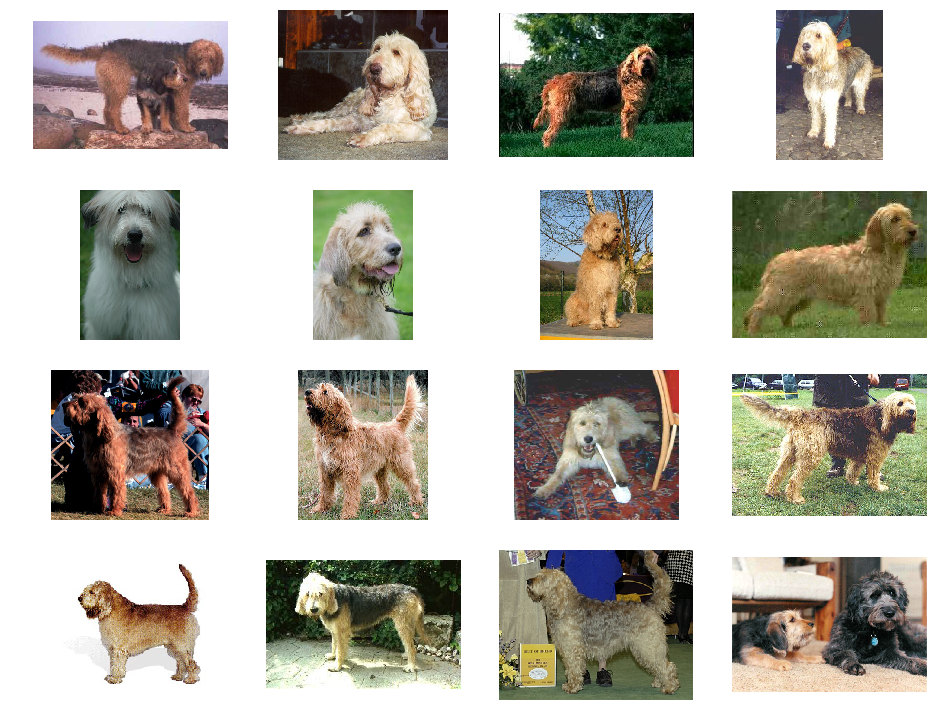

In [14]:
print(breed_list[0])
show_dir_images(breed_list[0], 16)

Visualize class distribution

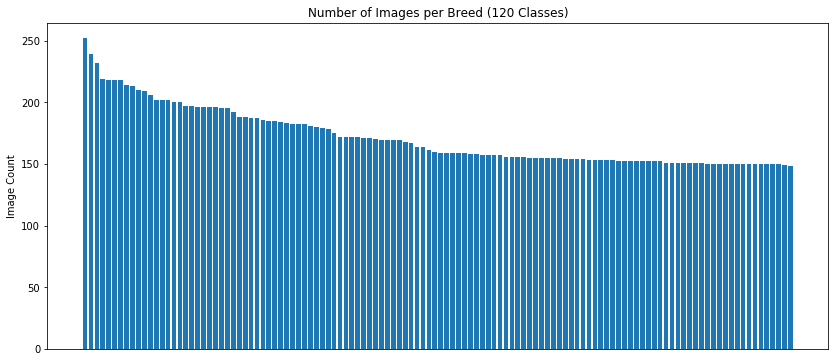

In [16]:
base_dir = "../input/stanford-dogs-dataset/images/Images/"

breed_counts = {}
for breed in breed_list:
    img_dir = os.path.join(base_dir, breed)
    breed_counts[breed] = len(os.listdir(img_dir))

df_counts = pd.DataFrame({"breed": list(breed_counts.keys()),
                          "count": list(breed_counts.values())})

df_counts = df_counts.sort_values("count", ascending=False)

plt.figure(figsize=(14,6))
plt.bar(df_counts["breed"], df_counts["count"])
plt.xticks([], [])     # too many labels, hide them
plt.ylabel("Image Count")
plt.title("Number of Images per Breed (120 Classes)")
plt.show()

Crop and save pictures - pick subset to reduce the training time


In [52]:
import os

print("CWD:", os.getcwd())
print("Exists ./data ?", os.path.exists("data"))
print("Exists /kaggle/working/data ?", os.path.exists("/kaggle/working/data"))

print("Contents of current dir:")
print(os.listdir("/kaggle/working"))

CWD: /kaggle/working
Exists ./data ? False
Exists /kaggle/working/data ? False
Contents of current dir:
[]


In [53]:
%%time


# ------------  Change max_breeds and max_per_breed for a smaller subset--------------
max_breeds = 10        # how many breeds you want to keep 
max_per_breed = 10     # how many images per breed
# ---------------------------------------------------------------------------

# make root output folder (won't crash if it already exists)
os.makedirs("data", exist_ok=True)

# choose a subset of breeds from your existing breed_list
subset_breeds = sorted(breed_list)[:max_breeds]
print(f"Using {len(subset_breeds)} breeds out of {len(breed_list)} total.")

# create subfolders for each chosen breed
for breed in subset_breeds:
    os.makedirs(os.path.join("data", breed), exist_ok=True)

print("Created {} folders to store cropped images of the different breeds."
      .format(len(os.listdir('data'))))

# crop & save only a limited number of images per chosen breed
for breed in subset_breeds:
    ann_dir = f"../input/stanford-dogs-dataset/annotations/Annotation/{breed}"
    ann_files = os.listdir(ann_dir)
    random.shuffle(ann_files)

    # only keep up to max_per_breed images per breed
    ann_files = ann_files[:max_per_breed]

    for file in ann_files:
        # NOTE: if your annotation files have .xml, you may need:
        # base = file.replace(".xml", "")
        # and then use base in the image path and save name.
        img = Image.open(
            '../input/stanford-dogs-dataset/images/Images/{}/{}.jpg'.format(breed, file)
        )

        tree = ET.parse(
            '../input/stanford-dogs-dataset/annotations/Annotation/{}/{}'.format(breed, file)
        )
        root_xml = tree.getroot()
        bndbox = root_xml.findall('object')[0].find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)

        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

print("Done cropping sample dataset.")



Using 10 breeds out of 120 total.
Created 10 folders to store cropped images of the different breeds.
Done cropping sample dataset.
CPU times: user 782 ms, sys: 45.1 ms, total: 828 ms
Wall time: 1.53 s


In [55]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in subset_breeds:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

Image Generator

In [56]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

Split train and test dataset

In [57]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

# Keras Pretrain DenseNet121 Model

In [58]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="../input/densenet-keras/DenseNet-BC-121-32-no-top.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

# Train last 6 layers only to expedite the process

In [59]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [60]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [61]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=5)

Epoch 1/5
3/3 [==============================] - 32s 11s/step - loss: 4.5957 - acc: 0.0215 - val_loss: 2.6031 - val_acc: 0.2000
Epoch 2/5
3/3 [==============================] - 21s 7s/step - loss: 3.0372 - acc: 0.1009 - val_loss: 1.7405 - val_acc: 0.4000
Epoch 3/5
3/3 [==============================] - 21s 7s/step - loss: 2.6585 - acc: 0.1413 - val_loss: 1.5591 - val_acc: 0.4667
Epoch 4/5
3/3 [==============================] - 22s 7s/step - loss: 2.4944 - acc: 0.1751 - val_loss: 1.4424 - val_acc: 0.4000
Epoch 5/5
3/3 [==============================] - 22s 7s/step - loss: 1.9181 - acc: 0.3123 - val_loss: 1.1163 - val_acc: 0.6000


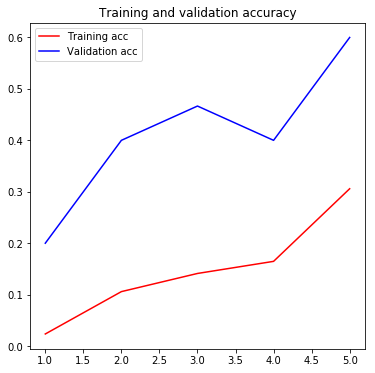

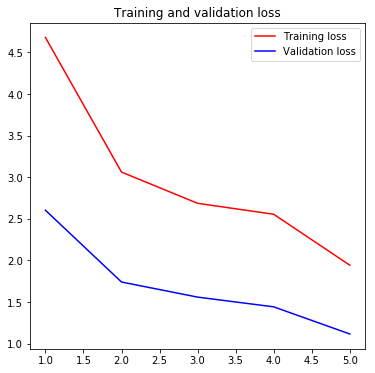

In [62]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

# Train all layers

In [63]:
for layer in model.layers[:]:
    layer.trainable = True

In [64]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [66]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=5,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/5
3/3 [==============================] - 22s 7s/step - loss: 1.4844 - acc: 0.5479 - val_loss: 0.9338 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to dog_breed_classifier_model.h5
Epoch 2/5
3/3 [==============================] - 21s 7s/step - loss: 1.5444 - acc: 0.5479 - val_loss: 0.8908 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.60000 to 0.66667, saving model to dog_breed_classifier_model.h5
Epoch 3/5
3/3 [==============================] - 22s 7s/step - loss: 1.2829 - acc: 0.5264 - val_loss: 0.7698 - val_acc: 0.7333

Epoch 00003: val_acc improved from 0.66667 to 0.73333, saving model to dog_breed_classifier_model.h5
Epoch 4/5
3/3 [==============================] - 22s 7s/step - loss: 0.9136 - acc: 0.6836 - val_loss: 0.7480 - val_acc: 0.7333

Epoch 00004: val_acc did not improve from 0.73333
Epoch 5/5
3/3 [==============================] - 22s 7s/step - loss: 1.1545 - acc: 0.6313 - val_loss: 0.6291 - val_acc: 0.8000

Epoch 0000

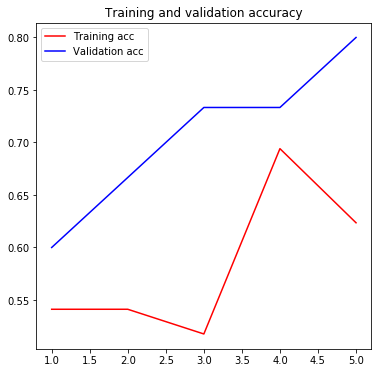

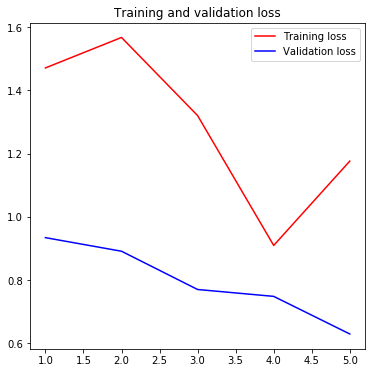

In [67]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [68]:
print(max(val_acc))

0.800000011920929


# DenseNet Result
Val Accuracy = 0.80

# SVM

Turn images into feature vectors 

In [74]:
IMG_SIZE = (64, 64)  # you can try 32x32, 64x64, etc.

def images_to_features(paths, img_size=IMG_SIZE):
    n = len(paths)
    X = np.zeros((n, img_size[0] * img_size[1] * 3), dtype=np.float32)

    for i, p in enumerate(paths):
        img = imread(p)                         # read image
        img = resize(img, img_size, anti_aliasing=True)  # resize to img_size
        img = img.astype(np.float32)
        img = img / 255.0                       # normalize to [0,1]
        X[i] = img.reshape(-1)                  # flatten to 1D
        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{n} images", end="\r")
    return X


In [75]:
X_train = images_to_features(train_paths, IMG_SIZE)
X_val   = images_to_features(val_paths,   IMG_SIZE)

print("X_train shape:", X_train.shape)
print("X_val shape:",   X_val.shape)

X_train shape: (85, 12288)
X_val shape: (15, 12288)


Scale features

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

Train the SVM model

In [78]:
svm_clf = LinearSVC(
    C=1.0,
    max_iter=5000
)

svm_clf.fit(X_train_scaled, y_train_int)

y_train_pred = svm_clf.predict(X_train_scaled)
y_val_pred   = svm_clf.predict(X_val_scaled)

train_acc = accuracy_score(y_train_int, y_train_pred)
val_acc   = accuracy_score(y_val_int,   y_val_pred)

print("SVM Train accuracy:", train_acc)
print("SVM Val accuracy:",   val_acc)

print(classification_report(y_val_int, y_val_pred))


SVM Train accuracy: 1.0
SVM Val accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         2
           3       0.20      1.00      0.33         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         3
           9       0.20      1.00      0.33         1

   micro avg       0.33      0.33      0.33        15
   macro avg       0.19      0.35      0.22        15
weighted avg       0.23      0.33      0.24        15



# SVM Result

overfitted

Train Accuracy = 1.00

Validation Accuracy = 0.33

Using raw pixel inputs - Raw pixels give the SVM no semantic understanding of shape, texture, or breed-related patterns — just color values.

Very small dataset (≈100 samples)

So it memorizes the training set perfectly but fails to generalize.

# Conclusion

We compared a classical machine learning baseline (Linear SVM on raw 64×64 RGB pixels) with a fine-tuned DenseNet121 model. The SVM achieved 100% training accuracy but only 33% validation accuracy, demonstrating heavy overfitting. In contrast, DenseNet121 achieved 80% validation accuracy, substantially outperforming the SVM. The deep model benefits from pretrained convolutional feature extraction and is able to generalize from a small number of examples, whereas the SVM struggles with high-dimensional raw pixel inputs and fails to capture the structural differences between dog breeds.
